# Linear Regression on Network Traffic

In [1]:
# Machine Learning Libraries
import numpy as np
import pandas as pd
from sklearn import linear_model

# Plotting Library
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

# Allow us to load modules from the parent directory
import sys
sys.path.append("../lib") 

# Libraries for Processing Network Traffic
import ipaddress
import netaddr
from parse_pcap import pcap_to_pandas, pcap_to_dict

In [2]:
pcap = pcap_to_pandas('../pcaps/pcap-20210604.pcap')
pcap = pcap.loc[:,['datetime','ip_src','ip_dst',
                   'length','port_src','port_dst','protocol']]

pcap['packets'] = 1
unique_flows = pcap.groupby(['ip_src', 'ip_dst', 'port_src', 'port_dst', 'protocol'])
udf = pd.DataFrame(unique_flows.agg(np.sum))
udf

length  packets
ip_src          ip_dst       port_src port_dst protocol                 
107.152.29.202  192.168.1.58 443.0    53440.0  TCP          519        2
                                      53486.0  TCP         3893        7
134.224.187.167 192.168.1.58 443.0    52571.0  TCP         9769       46
                             8801.0   51065.0  UDP          123        1
                                      57923.0  UDP       395557      524
...                                                         ...      ...
52.2.208.199    192.168.1.58 443.0    50629.0  TCP          189        2
                                      50762.0  TCP          189        2
                                      50767.0  TCP          189        2
54.163.224.3    192.168.1.58 443.0    50708.0  TCP          189        2
54.164.13.198   192.168.1.58 443.0    50578.0  TCP          123        1

[90 rows x 2 columns]

In [3]:
x = udf['packets'].values
y = udf['length'].values

In [4]:
###########
# Step 1: Create Linear Regression Model
linear_regression = linear_model.LinearRegression()

# Step 2: Train the Model Using the (x,y) Points
# Note: Reshape (-1,1) creates a column vector, which is what fit() expects.
linear_regression.fit(x.reshape(-1,1), y)

# Step 3: Input to predict function are x values that the model has never seen.
y_hat = linear_regression.predict(np.array([-2,1000]).reshape(-1,1))
###########

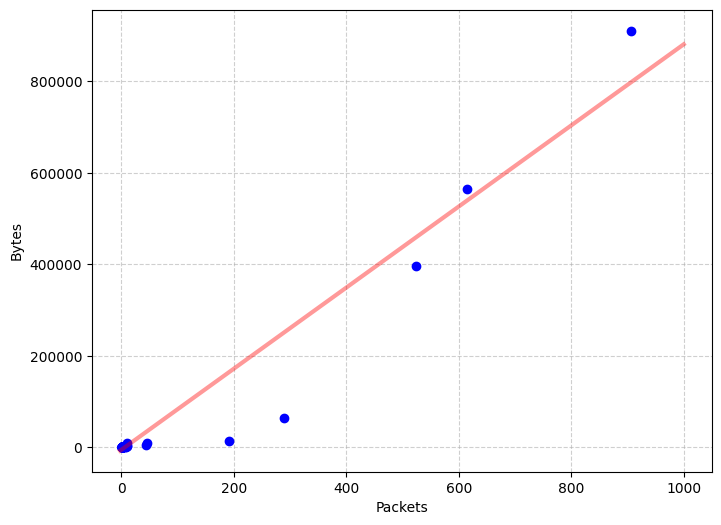

In [5]:
# Plot the results along with the points and previous line
# Plot the original points.
plt.plot(x, y, '.', color='blue', markersize=12)

# Predicted line from sklearn is in red
plt.plot([-2, 1000], y_hat, color='red', alpha=0.4, linewidth=3)

plt.grid(linestyle='--', alpha=0.6)
plt.xlabel('Packets')
plt.ylabel('Bytes')
plt.show()

### Evaluation: Error Computation

You can compute how well your manual fit is by computing the error, in terms of residual sum of squares.

In [6]:
from sklearn.metrics import mean_squared_error

rss = mean_squared_error(y, linear_regression.predict(x.reshape(-1,1)))
rss

861640898.1231976

## Polynomial Basis Expansion

Recall that one of the benefits of a polynomial feature expansion is that it is possible to fit a linear model to the resulting polynomial expansion.

We will do that below.  Let's first create the regular features and then the polynomial expansion.

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
poly_x = poly.fit_transform(x.reshape(-1,1))


linear_regression.fit(poly_x, y)

LinearRegression()

In [8]:
y_hat_poly = linear_regression.predict(poly.fit_transform(np.arange(1,1000,1).reshape(-1,1)))
y_hat_poly

array([ 1.73430966e+03,  1.12718947e+03,  5.27680039e+02, -6.42320354e+01,
       -6.48560175e+02, -1.22531780e+03, -1.79451832e+03, -2.35617517e+03,
       -2.91030175e+03, -3.45691149e+03, -3.99601780e+03, -4.52763411e+03,
       -5.05177382e+03, -5.56845037e+03, -6.07767716e+03, -6.57946761e+03,
       -7.07383515e+03, -7.56079319e+03, -8.04035515e+03, -8.51253444e+03,
       -8.97734449e+03, -9.43479872e+03, -9.88491053e+03, -1.03276934e+04,
       -1.07631606e+04, -1.11913257e+04, -1.16122021e+04, -1.20258031e+04,
       -1.24321423e+04, -1.28312329e+04, -1.32230885e+04, -1.36077225e+04,
       -1.39851482e+04, -1.43553791e+04, -1.47184287e+04, -1.50743102e+04,
       -1.54230372e+04, -1.57646231e+04, -1.60990812e+04, -1.64264251e+04,
       -1.67466680e+04, -1.70598235e+04, -1.73659050e+04, -1.76649258e+04,
       -1.79568994e+04, -1.82418393e+04, -1.85197587e+04, -1.87906712e+04,
       -1.90545902e+04, -1.93115290e+04, -1.95615011e+04, -1.98045200e+04,
       -2.00405990e+04, -

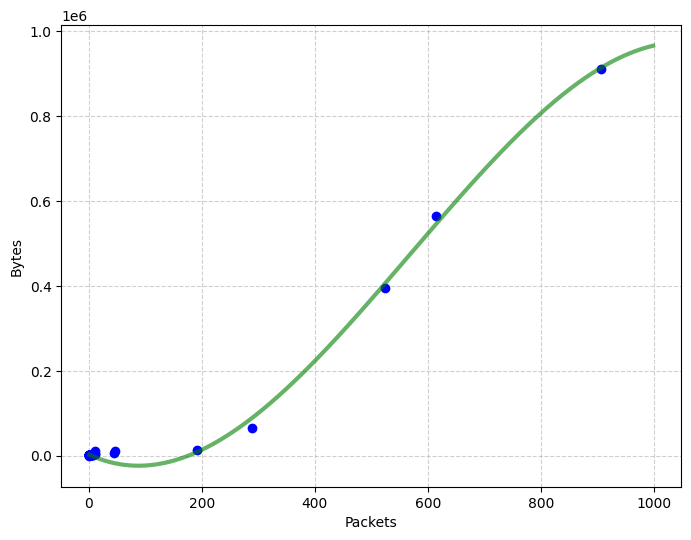

In [9]:
# Plot the results along with the points and previous line
# Plot the original points.
plt.plot(x, y, '.', color='blue', markersize=12)

# Plot the results along with the points and previous line
# Plot the original points.
plt.plot(np.arange(1,1000,1), y_hat_poly,  '-', color='green', linewidth=3, alpha=0.6)
plt.grid(linestyle='--', alpha=0.6)
plt.xlabel('Packets')
plt.ylabel('Bytes')
plt.show()

In [10]:
rss_poly = mean_squared_error(y, linear_regression.predict(poly.fit_transform(x.reshape(-1,1))))
improvement = rss - rss_poly

print('''
Original:\t\t\t{}
Polynomial Expansion:\t\t{}
Improvement:\t\t\t{}
'''.format(rss,rss_poly,improvement))


Original:			861640898.1231976
Polynomial Expansion:		31001399.15239412
Improvement:			830639498.9708034



## Reducing Error on Test Set

In the above example, we used a polynomial basis expansion to reduce the error on the training set. But, we have no test set, so it is difficult to tell whether the model above is overfit to the training data.

In order for us to tell whether this model is a good fit, we need to test it on data that the model has not yet seen. This requires splitting the data into a training set and a test set.

A typical split between training data and test data might be 80% training data, 20% test data. You can also perform this process repeatedly and average the results. This process is called **cross-validation**.

### Part 1

1. Take a packet trace using wireshark and load it into the notebook.
2. Perform a simple linear regression fit and a fit with basis expansion (same as above), comparing errors.

The first two steps are the same as above, but you might try doing this for a larger sample so that your network traffic has more flows (i.e., data points).

### Part 2

3. Use functions from sklearn to split the data into training and testing. (train_test_split, or sklearn's CV function).
4. How does model accuracy compare for different polynomial basis expansions? (n=1, 2, 3, ?) At what point is the model overfit?
5. Can you experiment with a regularization parameter to control or reduce overfitting?